In [ ]:
Part-1 : Transformers

In [2]:
!pip install datasets wandb transformers

In [3]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn.functional as F
from datasets import load_dataset
import random
import os

In [4]:
# Standard splits
train_dataset = load_dataset("tau/commonsense_qa", split="train[:-1000]")
valid_dataset = load_dataset("tau/commonsense_qa", split="train[-1000:]")
test_dataset  = load_dataset("tau/commonsense_qa", split="validation")

In [5]:
label_map = {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4}

def preprocess_example(example):
    question = example["question"]
    choices = example["choices"]["text"]
    input_texts = [f"{question} {choice}" for choice in choices]
    label = label_map[example["answerKey"]]
    return {"input_texts": input_texts, "label": label}

train_dataset = train_dataset.map(preprocess_example)
valid_dataset = valid_dataset.map(preprocess_example)
test_dataset  = test_dataset.map(preprocess_example)


In [12]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("albert-base-v2")

In [13]:
max_tokens = 0
for row in train_dataset:
    for ans in row['choices']['text']:
        tokens = tokenizer.encode(row['question'], ans)
        if len(tokens) > max_tokens:
            max_tokens = len(tokens)
print(f"Maximum tokenized input length (question + answer): {max_tokens}")

Maximum tokenized input length (question + answer): 73


In [14]:
class CommonsenseQADataset(Dataset):
    def __init__(self, hf_dataset, tokenizer, max_length=80):
        self.dataset = hf_dataset
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        input_texts = item["input_texts"]  # List of 5 strings
        label = item["label"]

        encoded = self.tokenizer(
            input_texts,
            padding="max_length",
            truncation=False,          
            max_length=self.max_length,
            return_tensors="pt"
        )

        return {
            "input_ids": encoded["input_ids"],           # shape: [5, seq_len]
            "attention_mask": encoded["attention_mask"], # shape: [5, seq_len]
            "label": torch.tensor(label)
        }


In [15]:
max_length = 80

train_data = CommonsenseQADataset(train_dataset, tokenizer, max_length=max_length)
valid_data = CommonsenseQADataset(valid_dataset, tokenizer, max_length=max_length)
test_data  = CommonsenseQADataset(test_dataset, tokenizer, max_length=max_length)

from torch.utils.data import DataLoader

train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=16)
test_loader  = DataLoader(test_data, batch_size=16)

In [7]:
from transformers import AlbertForMultipleChoice

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AlbertForMultipleChoice.from_pretrained("albert-base-v2").to(device)


Some weights of AlbertForMultipleChoice were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
print(model.albert.embeddings.word_embeddings.weight[0][:5])

tensor([ 0.0127,  0.0599, -0.0681, -0.0549, -0.0151], device='cuda:0',
       grad_fn=<SliceBackward0>)


In [17]:
import torch.nn as nn

def train_epoch(model, dataloader, optimizer, loss_fn, device):
    model.train()
    total_loss, correct, total = 0, 0, 0
    for batch in dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()
        logits = model(input_ids=input_ids, attention_mask=attention_mask).logits
        loss = loss_fn(logits, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        total_loss += loss.item() * input_ids.size(0)
        preds = torch.argmax(logits, dim=1)
        correct += (preds == labels).sum().item()
        total += input_ids.size(0)
    return total_loss / total, correct / total

def eval_epoch(model, dataloader, loss_fn, device):
    model.eval()
    total_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            logits = model(input_ids=input_ids, attention_mask=attention_mask).logits
            loss = loss_fn(logits, labels)

            total_loss += loss.item() * input_ids.size(0)
            preds = torch.argmax(logits, dim=1)
            correct += (preds == labels).sum().item()
            total += input_ids.size(0)
    return total_loss / total, correct / total


In [ ]:
import wandb
import itertools

# Define your search space (12 combinations)
learning_rates = [1e-5, 2e-5, 3e-5]
dropouts = [0.1, 0.2]
weight_decays = [0.0, 0.01]
batch_sizes = [16, 32]

search_space = list(itertools.product(learning_rates, dropouts, weight_decays, batch_sizes))
search_space = search_space[:12]  # Only first 12 combinations

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_epochs = 

best_val_acc = 0
best_hparams = None

for idx, (lr, dropout, wd, batch_size) in enumerate(search_space):
    wandb.init(project="commonsenseqa_albert_sweep", name=f"albert_run_{idx+1}", config={
        "learning_rate": lr,
        "dropout": dropout,
        "weight_decay": wd,
        "batch_size": batch_size,
        "epochs": num_epochs,
        "model": "albert-base-v2"
    })
    # Redefine DataLoaders for batch_size
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(valid_data, batch_size=batch_size)
    
    # Model with dropout override (if needed)
    model = get_albert_model(pretrained=True).to(device)
    for name, module in model.named_modules():
        if isinstance(module, nn.Dropout):
            module.p = dropout  # Override dropout
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=wd)
    loss_fn = nn.CrossEntropyLoss()
    best_epoch_val_acc = 0

    for epoch in range(num_epochs):
        train_loss, train_acc = train_epoch(model, train_loader, optimizer, loss_fn, device)
        val_loss, val_acc = eval_epoch(model, valid_loader, loss_fn, device)
        wandb.log({
            "epoch": epoch+1,
            "train_loss": train_loss,
            "train_accuracy": train_acc,
            "val_loss": val_loss,
            "val_accuracy": val_acc
        })
        if val_acc > best_epoch_val_acc:
            best_epoch_val_acc = val_acc

    if best_epoch_val_acc > best_val_acc:
        best_val_acc = best_epoch_val_acc
        best_hparams = {"learning_rate": lr, "dropout": dropout, "weight_decay": wd, "batch_size": batch_size}
    wandb.finish()

print("Best validation accuracy:", best_val_acc)
print("Best hyperparameters:", best_hparams)

wandb: ERROR Failed to detect the name of this notebook. You can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: aditi-sharma-00073 (aditi-sharma-00073-hochschule-luzern) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Some weights of AlbertForMultipleChoice were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


epoch,▁▃▅▆█
train_accuracy,▁██▅▂
train_loss,█▁▂▁▂
val_accuracy,▆▁▆█▆
val_loss,▁▆▁▅█
epoch,5
train_accuracy,0.19403
train_loss,1.61119
val_accuracy,0.228
val_loss,1.60942


Some weights of AlbertForMultipleChoice were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
Training the Pretrained Transformer

In [9]:
import wandb

wandb.init(project="commonsenseqa_albert_best-5", name="albert-finetune", config={
    "model": "AlbertForMultipleChoice",
    "epochs": 5,
    "batch_size": 16,
    "lr": 2e-5,
    "max_seq_len": max_seq_len,
})

wandb: ERROR Failed to detect the name of this notebook. You can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: aditi-sharma-00073 (aditi-sharma-00073-hochschule-luzern) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [10]:
optimizer = torch.optim.AdamW(model.parameters(), lr=wandb.config.lr)
loss_fn = nn.CrossEntropyLoss()

def train(model, dataloader):
    model.train()
    total_loss, correct, total = 0, 0, 0
    for batch in dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        logits = model(input_ids=input_ids, attention_mask=attention_mask).logits
        loss = loss_fn(logits, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * input_ids.size(0)
        preds = torch.argmax(logits, dim=1)
        correct += (preds == labels).sum().item()
        total += input_ids.size(0)

    avg_loss = total_loss / total
    accuracy = correct / total
    return avg_loss, accuracy

def evaluate(model, dataloader):
    model.eval()
    total_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            logits = model(input_ids=input_ids, attention_mask=attention_mask).logits
            loss = loss_fn(logits, labels)

            total_loss += loss.item() * input_ids.size(0)
            preds = torch.argmax(logits, dim=1)
            correct += (preds == labels).sum().item()
            total += input_ids.size(0)

    avg_loss = total_loss / total
    accuracy = correct / total
    return avg_loss, accuracy


In [11]:
for epoch in range(wandb.config.epochs):
    train_loss, train_acc = train(model, train_loader)
    val_loss, val_acc = evaluate(model, valid_loader)

    print(f"Epoch {epoch+1}: Train Loss={train_loss:.4f}, Acc={train_acc:.4f} | Val Loss={val_loss:.4f}, Acc={val_acc:.4f}")

    wandb.log({
        "epoch": epoch+1,
        "train_loss": train_loss,
        "train_accuracy": train_acc,
        "val_loss": val_loss,
        "val_accuracy": val_acc
    })

wandb.finish()

Epoch 1: Train Loss=1.3921, Acc=0.3951 | Val Loss=1.2177, Acc=0.5100
Epoch 2: Train Loss=1.0076, Acc=0.5976 | Val Loss=1.2157, Acc=0.5340
Epoch 3: Train Loss=0.6197, Acc=0.7626 | Val Loss=1.2563, Acc=0.5530
Epoch 4: Train Loss=0.3157, Acc=0.8881 | Val Loss=1.8659, Acc=0.5120
Epoch 5: Train Loss=0.1385, Acc=0.9533 | Val Loss=1.9028, Acc=0.5240


epoch,▁▃▅▆█
train_accuracy,▁▄▆▇█
train_loss,█▆▄▂▁
val_accuracy,▁▅█▁▃
val_loss,▁▁▁██
epoch,5
train_accuracy,0.95332
train_loss,0.1385
val_accuracy,0.524
val_loss,1.90281


In [ ]:
Evaluation on Pretrained Transformer:

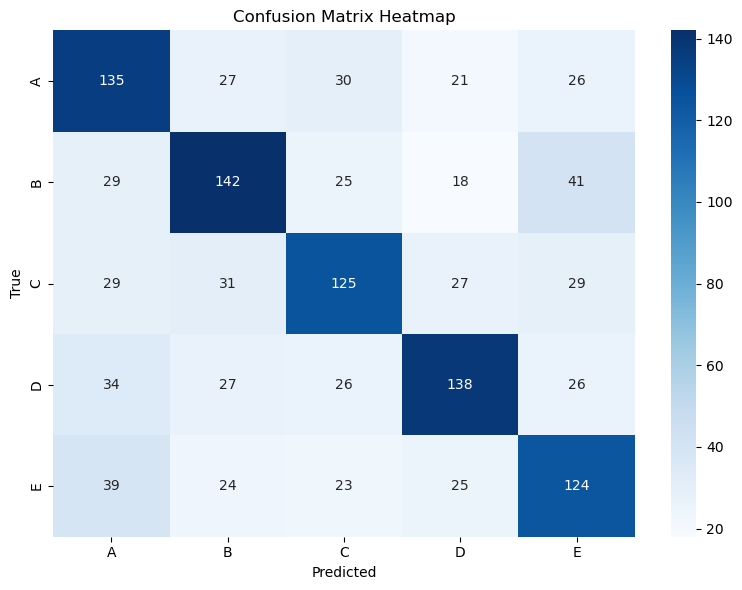

Test Accuracy: 0.5438
Test Precision: 0.5461
Test Recall: 0.5438
Test F1 Score: 0.5443

Classification Report:
              precision    recall  f1-score   support

           A       0.51      0.56      0.53       239
           B       0.57      0.56      0.56       255
           C       0.55      0.52      0.53       241
           D       0.60      0.55      0.57       251
           E       0.50      0.53      0.52       235

    accuracy                           0.54      1221
   macro avg       0.55      0.54      0.54      1221
weighted avg       0.55      0.54      0.54      1221


Confusion Matrix:
[[135  27  30  21  26]
 [ 29 142  25  18  41]
 [ 29  31 125  27  29]
 [ 34  27  26 138  26]
 [ 39  24  23  25 124]]


In [12]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def evaluate_and_plot(model, test_loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            
            logits = model(input_ids=input_ids, attention_mask=attention_mask).logits
            preds = torch.argmax(logits, dim=1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')
    clf_report = classification_report(all_labels, all_preds, target_names=['A', 'B', 'C', 'D', 'E'])
    cm = confusion_matrix(all_labels, all_preds)
    
    # Heatmap
    labels = ['A', 'B', 'C', 'D', 'E']
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix Heatmap')
    plt.tight_layout()
    plt.savefig('confusion_matrix_heatmap.png')
    plt.show()
    
    # Print metrics
    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Test Precision: {precision:.4f}")
    print(f"Test Recall: {recall:.4f}")
    print(f"Test F1 Score: {f1:.4f}")
    print("\nClassification Report:")
    print(clf_report)
    print("\nConfusion Matrix:")
    print(cm)
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'classification_report': clf_report,
        'confusion_matrix': cm
    }

# Usage:
test_metrics = evaluate_and_plot(model, test_loader, device)


In [ ]:
Randomly Initialised Transformer- AlbertForMultipleChoice

In [ ]:
# Model-1 (random weights, no pretraining) 
config = AlbertConfig.from_pretrained("albert-base-v2")
model = AlbertForMultipleChoice(config).to(device)
for name, module in model.named_modules():
    if isinstance(module, nn.Dropout):
        module.p = 0.1

optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
loss_fn = nn.CrossEntropyLoss()
num_epochs = 5

In [ ]:
Train the randomly initialised transformer on same hyperparameters as pretrained

In [16]:
wandb.init(
    project="commonsenseqa_random_albert-5",
    name="albert-random-weights",
    config={
        "model": "AlbertForMultipleChoice (random)",
        "epochs": num_epochs,
        "batch_size": 16,
        "lr": 2e-5,
        "max_seq_len": max_length,
    }
)


wandb: ERROR Failed to detect the name of this notebook. You can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: aditi-sharma-00073 (aditi-sharma-00073-hochschule-luzern) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [18]:
best_val_acc = 0

for epoch in range(num_epochs):
    train_loss, train_acc = train(model, train_loader)
    val_loss, val_acc = evaluate(model, valid_loader)

    print(f"Epoch {epoch+1}: Train Loss={train_loss:.4f}, Acc={train_acc:.4f} | Val Loss={val_loss:.4f}, Acc={val_acc:.4f}")

    wandb.log({
        "epoch": epoch+1,
        "train_loss": train_loss,
        "train_accuracy": train_acc,
        "val_loss": val_loss,
        "val_accuracy": val_acc
    })

    # Save best model by validation accuracy
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_albert_random_model.pt")

wandb.finish()

Epoch 1: Train Loss=1.6149, Acc=0.1911 | Val Loss=1.6094, Acc=0.2130
Epoch 2: Train Loss=1.6135, Acc=0.2007 | Val Loss=1.6094, Acc=0.2320
Epoch 3: Train Loss=1.6164, Acc=0.1917 | Val Loss=1.6094, Acc=0.2190
Epoch 4: Train Loss=1.6140, Acc=0.2003 | Val Loss=1.6094, Acc=0.2200
Epoch 5: Train Loss=1.6152, Acc=0.1987 | Val Loss=1.6094, Acc=0.2320


epoch,▁▃▅▆█
train_accuracy,▁█▂█▇
train_loss,▄▁█▂▅
val_accuracy,▁█▃▄█
val_loss,▁▄▆██
epoch,5
train_accuracy,0.19872
train_loss,1.61518
val_accuracy,0.232
val_loss,1.60943


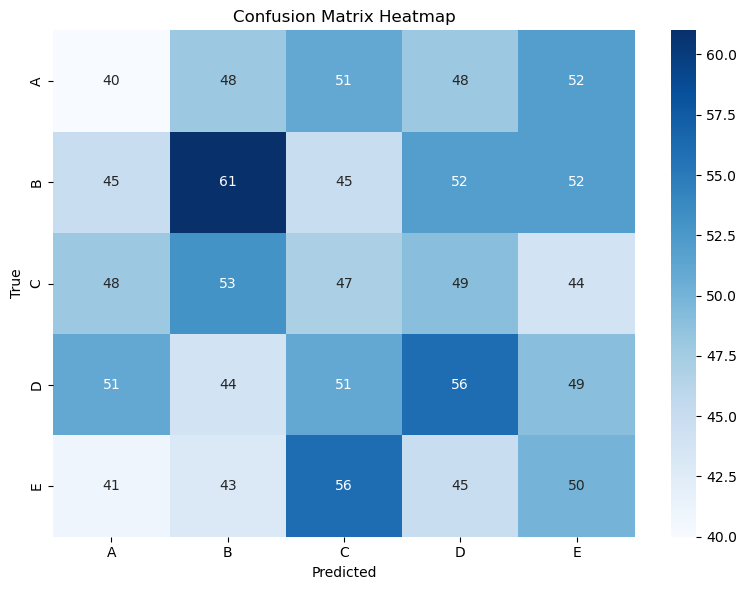

Test Accuracy: 0.2080
Test Precision: 0.2081
Test Recall: 0.2080
Test F1 Score: 0.2080

Classification Report:
              precision    recall  f1-score   support

           A       0.18      0.17      0.17       239
           B       0.24      0.24      0.24       255
           C       0.19      0.20      0.19       241
           D       0.22      0.22      0.22       251
           E       0.20      0.21      0.21       235

    accuracy                           0.21      1221
   macro avg       0.21      0.21      0.21      1221
weighted avg       0.21      0.21      0.21      1221


Confusion Matrix:
[[40 48 51 48 52]
 [45 61 45 52 52]
 [48 53 47 49 44]
 [51 44 51 56 49]
 [41 43 56 45 50]]


In [21]:
test_metrics = evaluate_and_plot(model, test_loader, device)